In [1]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')
sys.version

'3.5.1 |Continuum Analytics, Inc.| (default, Jan 29 2016, 15:01:46) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import os
import json
import datetime
import pytz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)
savefig = {'bbox_inches': 'tight', 'dpi': 300}

In [3]:
# Print integers nicely please ...
class _IntArrayFormatter(pd.formats.format.GenericArrayFormatter):

    def _format_strings(self):
        formatter = self.formatter or (lambda x: ' {:,}'.format(x))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values

pd.formats.format.IntArrayFormatter = _IntArrayFormatter

# Ink Master Live Season 8 Finale Twitter Voting

When twitter popularity decides who gets $100,000 and a car. Counting up the votes for contestants on the Ink Master season finale.

## Back story

Ink Master is a reality competition television series on Spike TV, where contestants are judged ont their tattooing ability. This year saw the 8th round of the competition and the live season finale ran last week on Tuesday December 6th.

Three of the original 18 contestants made it to the finale, where they had to ink a 6 hour tattoo that would be judged by twitter users. The person receiving the most votes would progress to the final stage of judging, while one of the other two would be eliminated on the spot.

## Voting details

After revealing the tattoos, users were given a small window of about 10 minutes in which votes would be counted. As per [the official rules](http://www.spike.com/about/ink-master-finale-voting-rules-s8), a user can cast as many votes as they want.

Tweets are counted as a vote if they contain one of the following hashtags: #InkKelly, #InkGian, or #InkRyan - depending on who the vote is cast for. Here were the three competitors and their final tattoos:

https://www.instagram.com/p/BNqAxzojN9s/?taken-by=kellydotylovessoup

__Kelly Doty__

![](input/ink_master_finale_gallery_live_tattoo_2.jpg)

__Gian Karle Cruz__

![](input/ink_master_finale_gallery_live_tattoo_3.jpg)

__Ryan Ashley Malarkey__

![](input/ink_master_finale_gallery_live_tattoo_1.jpg)

## Counting up the tweets
### Invesitage tweet data

In [4]:
# Some will be truncated :(
for line in open('input/#InkKelly_2016-12-03_to_2016-12-10.json', 'r'):
    tweet = json.loads(line)
    if tweet['truncated']:
        break

In [5]:
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Dec 09 01:12:23 +0000 2016',
 'entities': {'hashtags': [{'indices': [0, 15], 'text': 'Spikeinkmaster'},
   {'indices': [68, 77], 'text': 'inkkelly'}],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/i/web/status/8…',
    'expanded_url': 'https://twitter.com/i/web/status/807030094820679682',
    'indices': [117, 140],
    'url': 'https://t.co/GRF2XRPjdI'}],
  'user_mentions': []},
 'favorite_count': 1,
 'favorited': False,
 'geo': None,
 'id': 807030094820679682,
 'id_str': '807030094820679682',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 2,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/android" rel="

In [6]:
[tag['text'] for tag in tweet['entities']['hashtags']]

['Spikeinkmaster', 'inkkelly']

### Load all data

In [7]:
files = (open(file, 'r') for file in ['input/#InkKelly_2016-12-03_to_2016-12-10.json',
                                      'input/#InkGian_2016-12-03_to_2016-12-10.json',
                                      'input/#InkRyan_2016-12-03_to_2016-12-10.json'])

In [8]:
data = {'text': [], 'screen_name': [], 'created_at': [],
        '#InkKelly': [], '#InkGian': [], '#InkRyan': []}
 
for f in files:
    for line in f:
        t = json.loads(line)
        data['text'].append(t['text'])
        data['screen_name'].append(t['user']['screen_name'])
        data['created_at'].append(t['created_at'])
        data['#InkKelly'].append('inkkelly' in [tag['text'].lower() for tag in t['entities']['hashtags']])
        data['#InkGian'].append('inkgian' in [tag['text'].lower() for tag in t['entities']['hashtags']])
        data['#InkRyan'].append('inkryan' in [tag['text'].lower() for tag in t['entities']['hashtags']])    
    
df = pd.DataFrame(data)

### Clean up data

In [9]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

118293
115244


In [10]:
# Convert from UTC to Eastern datetimes

# This is one way
# dates = pd.to_datetime(df.created_at)
# dates = [pytz.timezone('UTC').localize(d) for d in dates]
# df.created_at = [d.astimezone(pytz.timezone('US/Eastern')) for d in dates]

# This is an easier way
df.created_at = [d - datetime.timedelta(hours=5) for d in pd.to_datetime(df.created_at)]

There are some rows without any of the required hashtags, we'll remove these.

In [11]:
df[df[['#InkKelly', '#InkGian', '#InkRyan']].sum(axis=1) == 0]

,#InkGian,#InkKelly,#InkRyan,created_at,screen_name,text
"29,422",False,False,False,2016-12-06 22:53:29,Winederland,"I don't love Japanese style. I wish @giankarle got a different style. But, it's solid and he deserves to be in it.… https://t.co/gm8JgeEfZM"
"43,657",False,False,False,2016-12-06 22:33:02,urkiddingrite,#ìnkgian
"45,857",False,False,False,2016-12-07 10:39:01,mariamzzarella,"Who is Ryan Ashley Malarkey? Tattoo artist becomes first woman to win ""Ink Master"" https://t.co/LFkx2Vl86q… https://t.co/Qaj2HkT3Kb"
"45,913",False,False,False,2016-12-07 09:37:03,StarlitNovember,Just finished watching #spikeInkMaster Finale. Huge CONGRATULATIONS to the Talented and lovely @RyanAshleyM! Girl y… https://t.co/KKal4ujv9c
"48,052",False,False,False,2016-12-07 00:41:48,MissCadaverous,"CONGRATS @RyanAshleyM ❤️❤️❤️ YOU DID IT!!! Obviously, with how amazing and talented you are, it was destined to hap… https://t.co/G5Yt3MDCXF"
"49,386",False,False,False,2016-12-06 23:33:32,histteachlife,"Well deserved!!! So happy to not only see a woman win, but an extremely talented woman!! @RyanAshleyM #inkmaster… https://t.co/aVjHKm4Tno"
"52,807",False,False,False,2016-12-06 23:01:46,eli_11swerve,Not into women with pierced noses but for her I'll make an exception &amp; she does badass tattoos! Ryan for the first… https://t.co/3TfNcTKej6
"54,893",False,False,False,2016-12-06 22:50:11,_taylorharding,"@RyanAshleyM YOU'RE TRENDINNNNNGGGG OMG! Hope you bring it home girl, you've earned it 💕 Lots of love from New Zeal… https://t.co/t6EM9ayW1R"
"67,475",False,False,False,2016-12-06 22:41:23,ivywillgrow,I have been fiercely rooting for @RyanAshleyM since the first episode of @SpikeInkMaster. Such an outstanding tatto… https://t.co/wUjcK4w63I
"74,618",False,False,False,2016-12-06 22:39:07,djdesimone085,This is awesome and I love the work you do and I have been your fan since the season started and I knew you make it… https://t.co/hPpN3n1Y4l


In [12]:
df = df[~(df[['#InkKelly', '#InkGian', '#InkRyan']].sum(axis=1) == 0)]

### Assumptions

Retweets are assumed not to count, so let's remove those.

In [13]:
df.text.str.startswith('RT').sum()

37517

In [14]:
df = df[~df.text.str.startswith('RT')]

The rules for tweets contining votes for more than one competitor are unclear, so we'll allow this. Here is how many times it occurs:

In [15]:
(df[['#InkKelly', '#InkGian', '#InkRyan']].sum(axis=1) > 1).sum()

1266

In [16]:
print('%d%%' % ((df[['#InkKelly', '#InkGian', '#InkRyan']].sum(axis=1) > 1).sum() / len(df) * 100))

1%


The show ran from 10-11 PM EST so we'll pad the edges and look at tweets posted from 9-12 PM EST.

In [17]:
x1 = datetime.datetime.strptime('06/12/16-21', '%d/%m/%y-%H')
x2 = datetime.datetime.strptime('07/12/16-00', '%d/%m/%y-%H')

print(len(df))
df = df[df.created_at.apply(lambda x: x1 <= x < x2)]
print(len(df))

77716
74848


In [18]:
df = df.sort_values('created_at').reset_index(drop=True)

### Analysis

In [19]:
tags = ['#InkKelly', '#InkGian', '#InkRyan']
df[tags].sum()

#InkKelly    17,446
#InkGian     13,101
#InkRyan     45,888
dtype: int64

The time frame where tweets counted as votes was roughly from 10:32 to 10:45 EST. Let's re-calculate the votes from within just that period.

In [20]:
x1 = datetime.datetime.strptime('06/12/16-22:32', '%d/%m/%y-%H:%M')
x2 = datetime.datetime.strptime('06/12/16-22:45', '%d/%m/%y-%H:%M')
df[df.created_at.apply(lambda x: x1 <= x < x2)][tags].sum()

#InkKelly    14,890
#InkGian     11,068
#InkRyan     40,241
dtype: int64

In [21]:
labels = ['Kelly', 'Gian', 'Ryan']
colors = ['#fc50dc', '#ffd51e', '#595959']

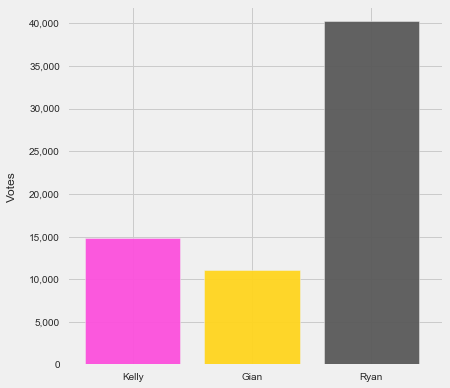

In [22]:
fig = plt.figure(figsize=(6, 6))

vals = df[df.created_at.apply(lambda x: x1 <= x < x2)][tags].sum().values

plt.bar([1, 2, 3], vals, color=colors, alpha=0.95)
plt.xlim(0.85, 4)
plt.xticks([1.4, 2.4, 3.4], labels)
plt.ylabel('Votes', fontsize=12, labelpad=12)
plt.ylim(0, 42000)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('output/total_votes_bar.png', **savefig)

10.0 seconds per bin


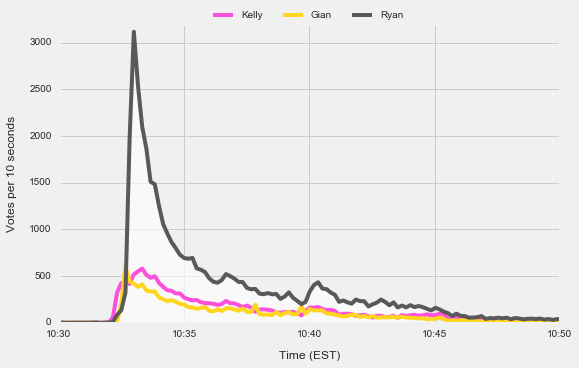

In [23]:
def datetime_histogram(df, title):
    
    date_timestamps = [[date.timestamp() for date in
                        df[df[tag] == True].created_at]
                       for tag in tags]

    # Be careful here to make sure each histogram has the same bin width
    hists = []
    hists.append(np.histogram(date_timestamps[0], bins=740))
    hists.append(np.histogram(date_timestamps[1], bins=hists[0][1]))
    hists.append(np.histogram(date_timestamps[2], bins=hists[0][1]))

    hist_dates = [datetime.datetime.fromtimestamp(t) for t in hists[0][1][:-1]]

    print('%.1f seconds per bin' % (hist_dates[1] - hist_dates[0]).total_seconds())

    fig, ax = plt.subplots(figsize=(8, 5))

    # Fill area when tweets count for votes
    x1 = datetime.datetime.strptime('06/12/16-22:32', '%d/%m/%y-%H:%M')
    x2 = datetime.datetime.strptime('06/12/16-22:45', '%d/%m/%y-%H:%M')
    x1_ = list(map(lambda x: abs((x - x1).total_seconds()), hist_dates))
    x2_ = list(map(lambda x: abs((x - x2).total_seconds()), hist_dates))
    x1_index = x1_.index(min(x1_))
    x2_index = x2_.index(min(x2_))
    x_fill = hist_dates[x1_index:x2_index]
    y1_fill = 0
    y2_fill = [max(vals) for vals in zip(*[h[0] for h in hists])][x1_index:x2_index]
    # ax.fill_between(x_fill, y1_fill, y2_fill, color='#b3b3b5', alpha=0.5)
    ax.fill_between(x_fill, y1_fill, y2_fill, color='white', alpha=0.65)

    # Plot the tweets
    ax.plot(hist_dates, hists[0][0], color=colors[0], label=labels[0])
    ax.plot(hist_dates, hists[1][0], color=colors[1], label=labels[1])
    ax.plot(hist_dates, hists[2][0], color=colors[2], label=labels[2])

    # Can set xlim using datetimes
    x1 = datetime.datetime.strptime('06/12/16-22:30', '%d/%m/%y-%H:%M')
    x2 = datetime.datetime.strptime('06/12/16-22:50', '%d/%m/%y-%H:%M')
    ax.set_xlim(x1, x2)
    ax.set_ylim(0, 3200)

    ax.set_ylabel('Votes per %d seconds'
                  % (hist_dates[1] - hist_dates[0]).total_seconds(),
                  fontsize=12, labelpad=12)
    ax.set_xlabel('Time (EST)',
                  fontsize=12, labelpad=12)

    # Format times
    # Note that the hashtag "#" is a windows specific formatting option
    # for other platforms it may be "-"
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%#I:%M'))

    # Add legend
    plt.legend(loc=(0.3, 1), ncol=3)

    # Save it
    plt.savefig('output/'+title+'.png', **savefig)
    
datetime_histogram(df, title='all_vote_tweets')

Kelly had the initial lead, but Ryan clearly dominated the popular vote. How would this look if only one vote was counted per user?

In [24]:
dfs = [df[df[tag] == True] for tag in tags]
dfs = [df.drop_duplicates('screen_name') for df in dfs]
df_one_vote = pd.concat(dfs)

'Removing %.1f%% of the data' % ((len(df) - len(df_one_vote)) / len(df) * 100)

'Removing 28.5% of the data'

10.0 seconds per bin


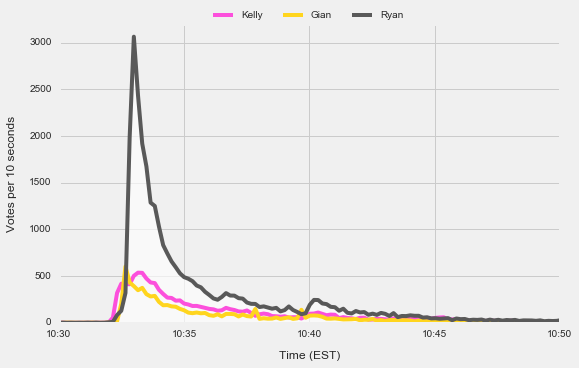

In [25]:
datetime_histogram(df_one_vote, title='no_duplicate_vote_tweets')

It looks nearly identical, differences are more noticeable after the initial spike for each contestant.

Which users had the most votes and who did they vote for?

In [26]:
x1 = datetime.datetime.strptime('06/12/16-22:32', '%d/%m/%y-%H:%M')
x2 = datetime.datetime.strptime('06/12/16-22:45', '%d/%m/%y-%H:%M')
df_counts = df[df.created_at.apply(lambda x: x1 <= x < x2)]

df_counts = df_counts.groupby('screen_name')[tags].sum().reset_index()
df_counts[tags] = df_counts[tags].astype(int)
df_counts['Total Votes'] = df_counts[tags].sum(axis=1)
df_counts = df_counts.sort_values('Total Votes', ascending=False)
df_counts.index = list(range(1, len(df_counts) + 1))
df_counts.columns = ['Screen Name'] + list(df_counts.columns)[1:]
df_counts.head(8)

,Screen Name,#InkKelly,#InkGian,#InkRyan,Total Votes
1,Boogotshot,0,168,0,168
2,burgerb0yw0nder,0,88,0,88
3,RestlessKeatsxo,0,0,87,87
4,princess_emrick,0,0,80,80
5,crucio_court,0,0,78,78
6,solarskyes,0,66,0,66
7,crybbycrybby,62,0,0,62
8,sorryimgabs,0,0,62,62


How many people voted more than once?

In [27]:
all_names = df.screen_name.unique()
multipost_names = df.screen_name[df.screen_name.duplicated()].unique()

print('%d%% of users posted only once' % ((len(all_names) - len(multipost_names)) / len(all_names) * 100))

76% of users posted only once


Mean and median for users who posted more than once.

In [28]:
df_multiple_votes = df[df.screen_name.apply(lambda x: x in multipost_names)]

In [29]:
multiple_user_votes = df_multiple_votes.groupby('screen_name')[tags].sum().sum(axis=1)
print('Mean   = %.1f' % multiple_user_votes.mean())
print('Median = %.1f' % multiple_user_votes.median())

Mean   = 3.3
Median = 2.0
